# Spectral Analysis - Discrete Interval Groups

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import networkx as nx
import math

In [2]:
data = {}
data['raw_data'] = {}
data['raw_data']['igt_orl'] = pd.read_csv('data/parameter_igt_orl.csv')
data['raw_data']['igt_pvl_delta'] = pd.read_csv('data/parameter_igt_pvl_delta.csv')
data['raw_data']['igt_vpp'] = pd.read_csv('data/parameters_igt_vpp.csv')
dataset_names = ['igt_orl', 'igt_pvl_delta', 'igt_vpp']

Interval Groups

The next idea I want to try is to see what the data would look like if we gave subjects which fall within the same interval a score

This makes the data more discrete. There were many connections in the last Spectral clustering notebook and this made it almost impossible to apply clustering and it was difficult to visualise groups.

We break the data up into 1000 equal groups and go from there. The idea is explained further in the code below

In [3]:
# these are columns which we dont want to connect
bad_cols = ['group', 'SubID', 'subjID']
data['processed_data'] = {}
data['processed_data']['column_names'] = {}
data['processed_data']['by_column'] = {}
data['processed_data']['interval_groups'] = {}
data['processed_data']['matrices'] = {}
data['processed_data']['matrices']['interval_groups'] = {}
for dataset_name in data['raw_data']:
    dataset = data['raw_data'][dataset_name]
    data_points = list(dataset.columns)
    for col in bad_cols:
        if col in data_points:
            data_points.remove(col)
    data['processed_data']['column_names'][dataset_name] = data_points
    data['processed_data']['interval_groups'][dataset_name] = {}
    data['processed_data']['by_column'][dataset_name] = {}
    data['processed_data']['matrices']['interval_groups'][dataset_name] = {}
    # build interval groups
    for data_point in data_points:
        data['processed_data']['by_column'][dataset_name][data_point] = dataset[data_point]
        groups = {}
        data_column = dataset[data_point]
        # we split the range of the data in this column at 10 equal points and split the subjects into groups
        intervals = list(np.linspace(min(data_column), max(data_column), 1001))
        i = 0
        while i < len(intervals)-1:
            mini = intervals[i]
            maxi = intervals[i+1]
            groups[maxi] = []
            for j, val in enumerate(data_column):
                if mini < val <= maxi:
                    groups[maxi].append(j)
            if i == 0:
                groups[maxi].append(list(data_column).index(min(data_column)))
            i = i + 1
        # reassign group ids
        i = 0
        new_groups = {}
        for group in groups:
            new_groups[i] = groups[group]
#             del groups[group]
            i = i + 1
        data['processed_data']['interval_groups'][dataset_name][data_point] = new_groups
        # next we want to build feature matrices based on these groups of subjects which fall within
        # the same interval for this column in the dataset
        # if the subjects are in the same group they get a relationship. simple
        matrix = np.zeros((153,153), dtype=float)
        for group in new_groups:
            connected_subjects = new_groups[group]
            for cs1 in connected_subjects:
                for cs2 in connected_subjects:
                    if cs1 != cs2:
                        if matrix[cs1, cs2] == 0:
                            matrix[cs1, cs2] = 1
        #test the matrix to ensure it has been built correctly
        
        data['processed_data']['matrices']['interval_groups'][dataset_name][data_point] = matrix

Next, we add these matrices so that we can see, across the features given, which subjects fall within the same intervals the most and which subjects they are closest to

In [4]:
for dataset_name in data['raw_data']:
    master_matrix = np.zeros((153,153), dtype=float)
    for data_point in data['processed_data']['column_names'][dataset_name]:
        master_matrix = master_matrix + data['processed_data']['matrices']['interval_groups'][dataset_name][data_point]
    data['processed_data']['matrices']['interval_groups'][dataset_name]['master'] = master_matrix

Connected Graph for igt_orl
--------------------


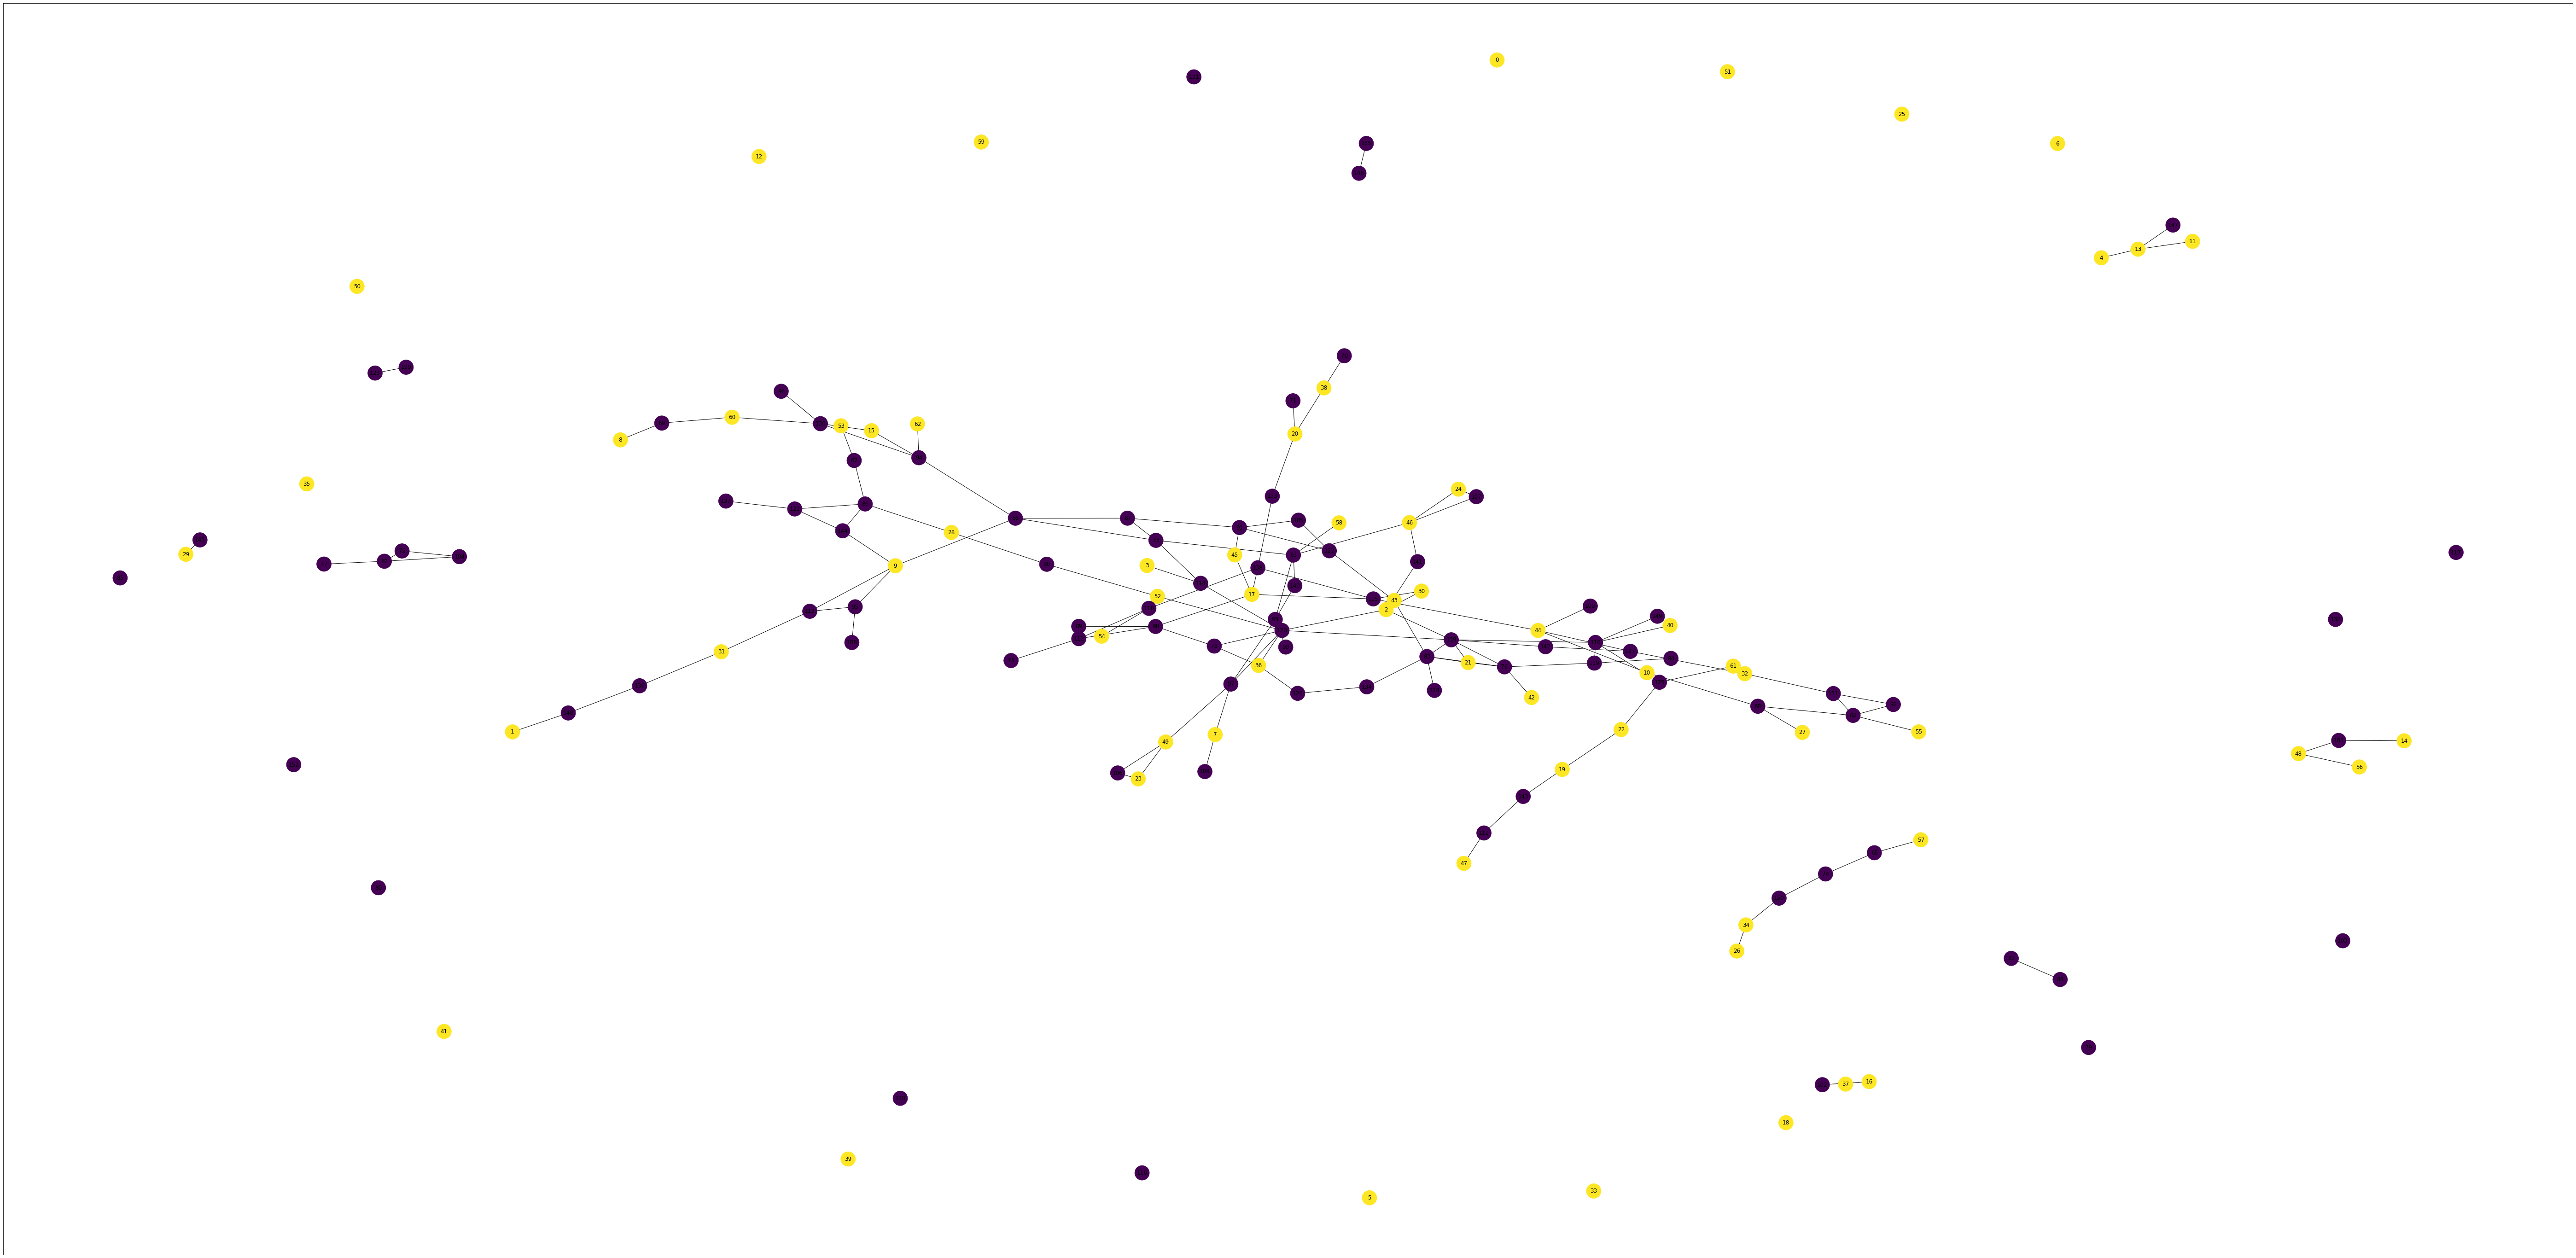

Connected Graph for igt_pvl_delta
--------------------


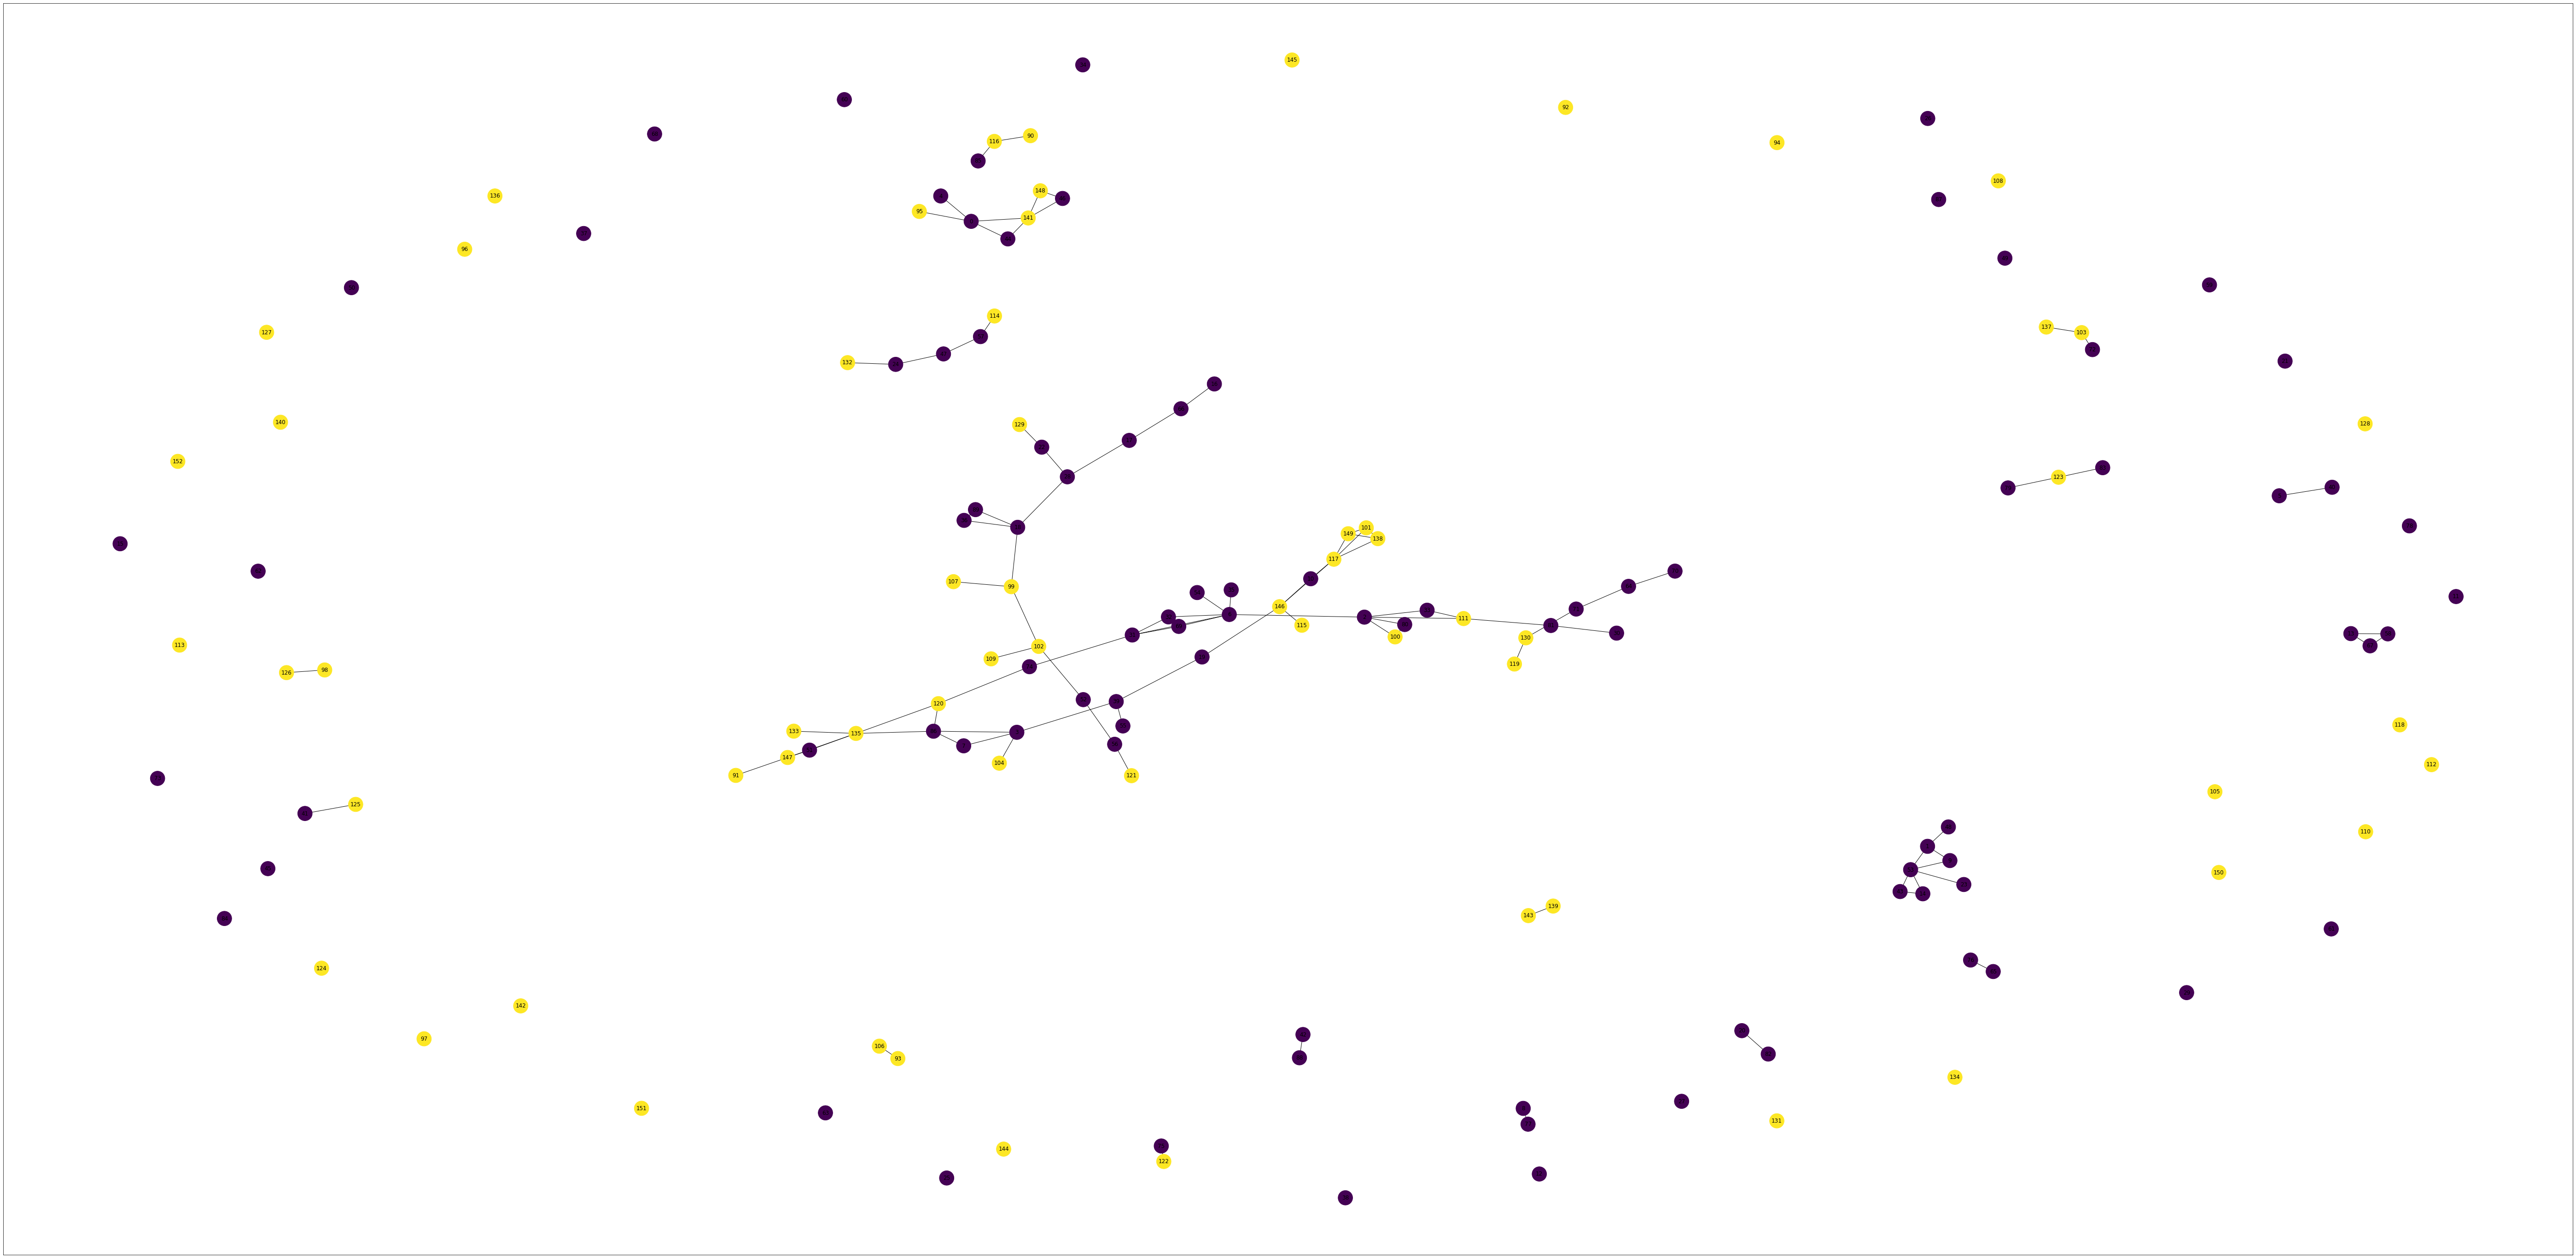

Connected Graph for igt_vpp
--------------------


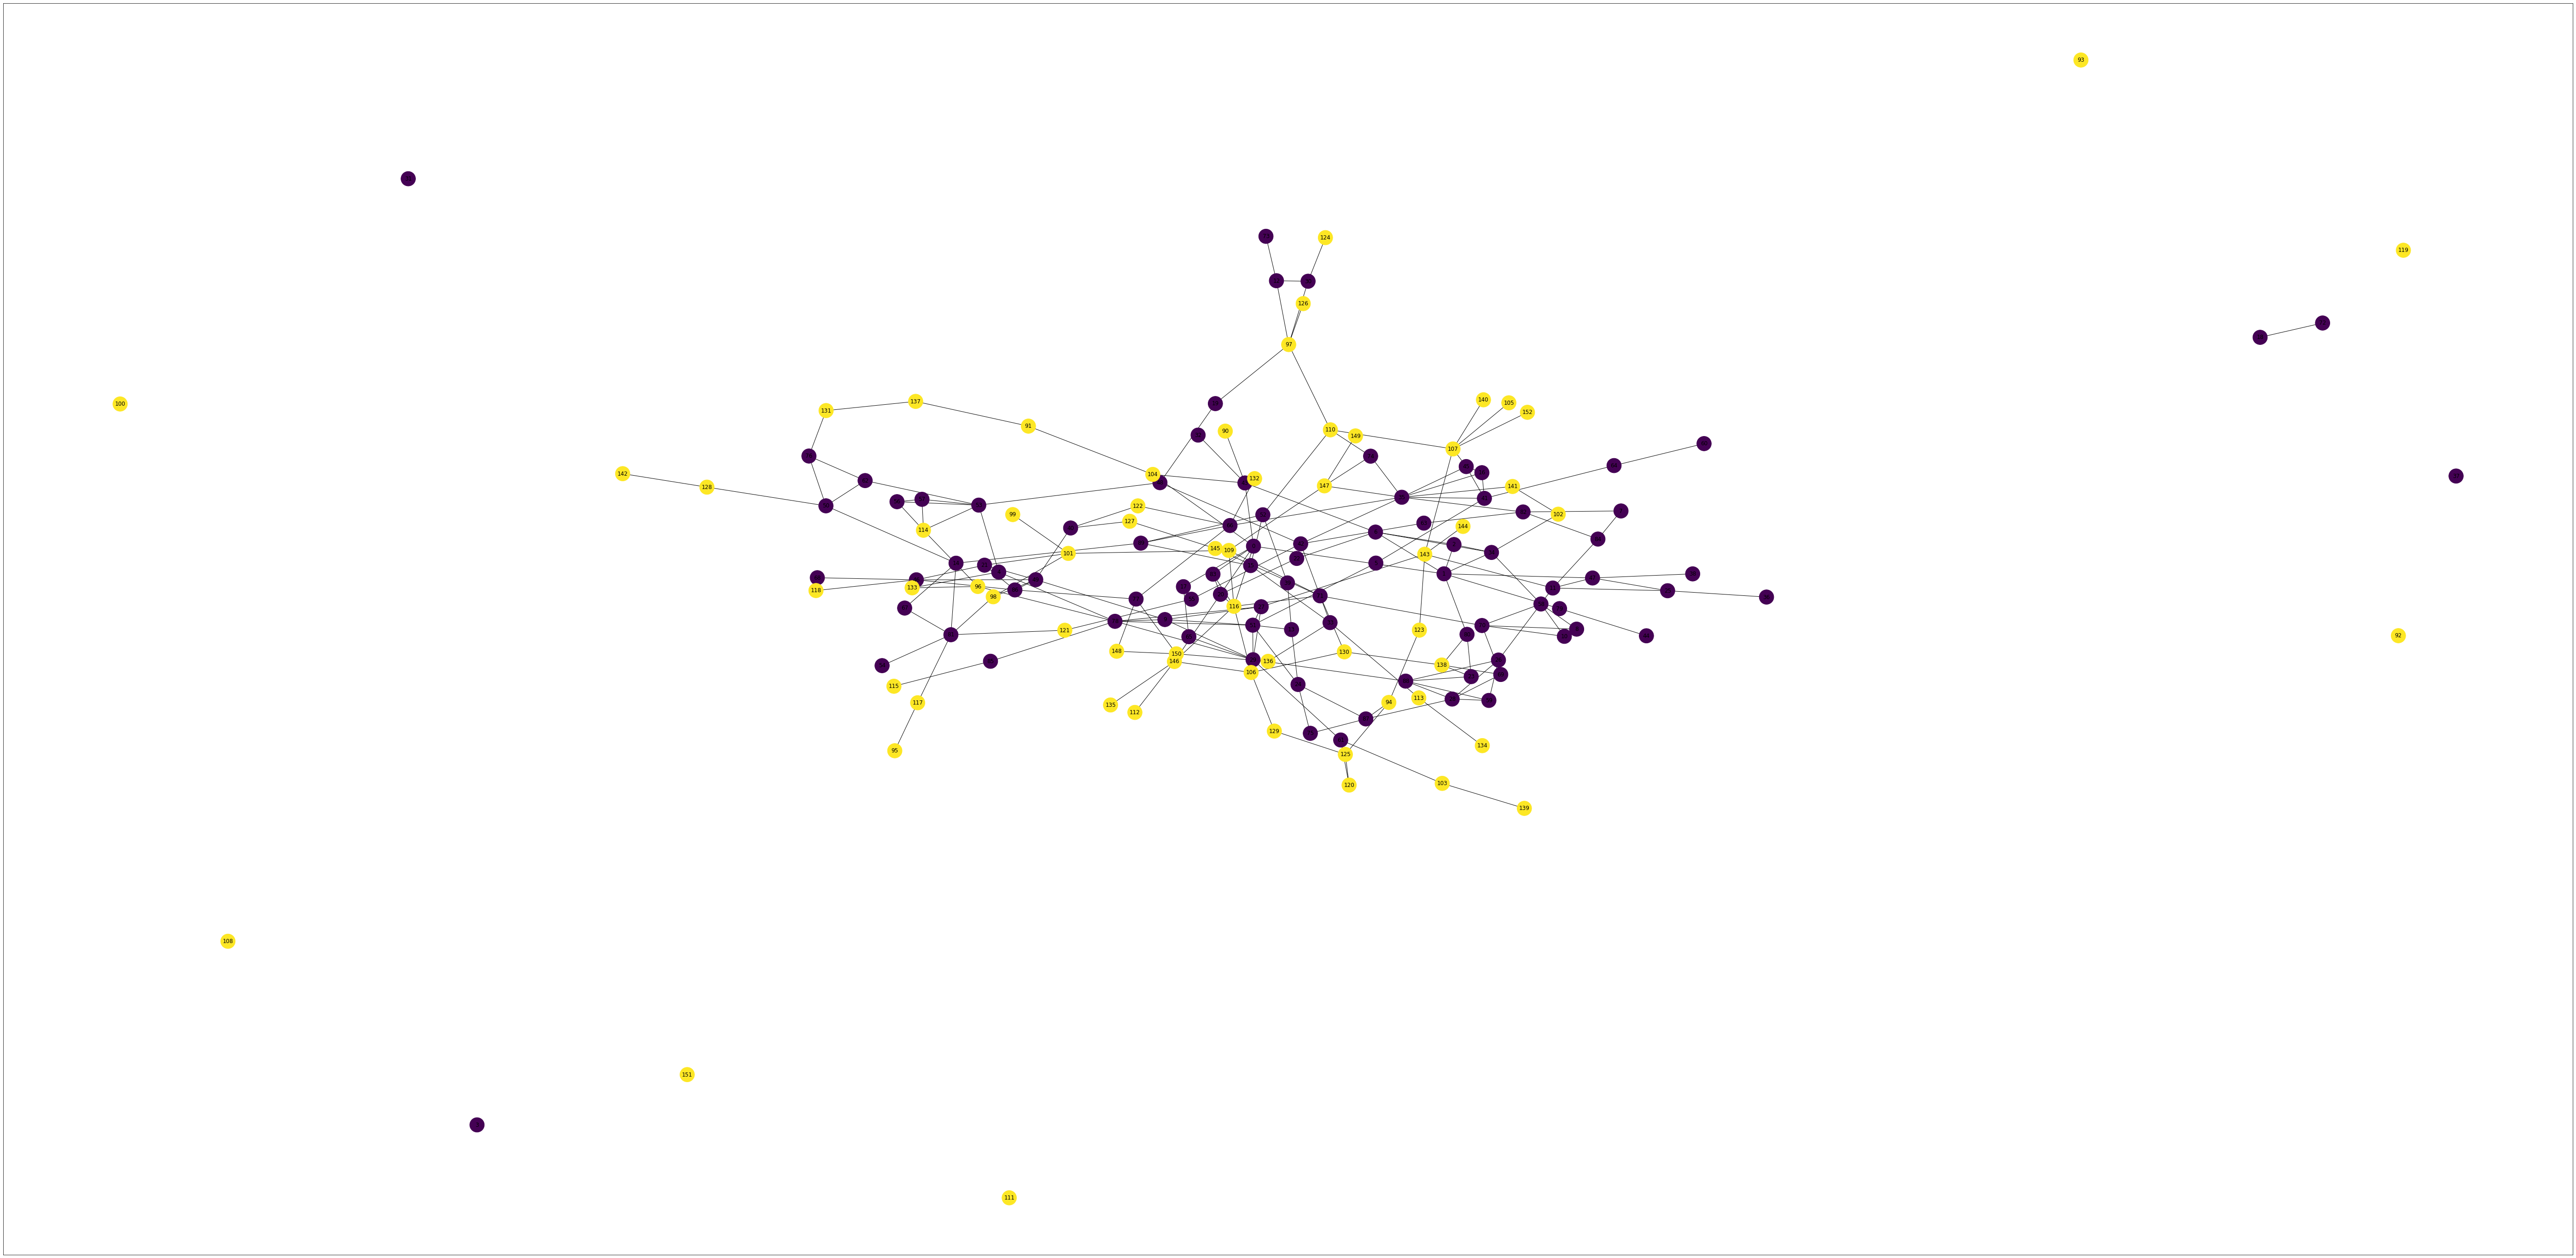

In [5]:
data['processed_data']['labels'] = {}
for dataset_name in data['raw_data']:
    labels = []
    if 'group' in data['raw_data'][dataset_name]:
        group_labels = data['raw_data'][dataset_name]['group']
    elif 'subjID' in data['raw_data'][dataset_name]:
        group_labels = data['raw_data'][dataset_name]['subjID']
    for label in group_labels:
        if label == 'young':
            labels.append(0)
        if label == 'old':
            labels.append(1)
    data['processed_data']['labels'][dataset_name] = labels
    print(f"Connected Graph for {dataset_name}")
    print('--------------------')
    plt.figure(figsize=(100,50))
    B = nx.convert_matrix.from_numpy_array(data['processed_data']['matrices']['interval_groups'][dataset_name]['master'])
    nx.draw_networkx(B, with_labels=True, node_color=labels, node_size=1000, font_color='black')
    plt.show()


As we can see there are quite a few isolated nodes. These nodes are clusters themselves.  
If we include them in a clustering algorithm like KMeans they will just distract the algorithm and make it much more difficult to cluster the large connected components in the centre.  
  
What we will do is use the kmeans algorithm to identify connected components within the graph.  
Then we will eliminate all but the largest component.  
Then we can run KMeans on the central component properly and see if we can break it up further into smaller clusters.  

We will try this in the next notebook.